In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
frames = list()
results = pd.read_csv("input/train.csv")

for i in range(1,19):
    exp = '0' + str(i) if i < 10 else str(i)
    frame = pd.read_csv("input/experiment_{}.csv".format(exp))
    row = results[results['No'] == i]
    frame['target'] = 1 if row.iloc[0]['tool_condition'] == 'worn' else 0
    frames.append(frame)

df = pd.concat(frames, ignore_index = True)
df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,target
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,0
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,0
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,0
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,0
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,0


In [15]:
# Transform process name in number
le = LabelEncoder()
le.fit(df['Machining_Process'])
df['Machining_Process'] = le.transform(df['Machining_Process'])




In [18]:
df.shape

(25286, 49)

In [17]:
# Create np arrays and split train/test sets
y = np.array(df['target'])
x = df.drop('target', axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)


In [26]:
print(x_train.shape, x_test.shape)

(20228, 48) (5058, 48)


In [16]:
# Target distribution (count values)
print("Target distribution - 1 worn; 0 unworn:")
print(df['target'].value_counts())

Target distribution - 1 worn; 0 unworn:
target
1    13308
0    11978
Name: count, dtype: int64


In [34]:
df.head

<bound method NDFrame.head of        X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0                  198.0               0.00                   0.00   
1                  198.0             -10.80                -350.00   
2                  196.0             -17.80                  -6.25   
3                  194.0             -18.00                   0.00   
4                  193.0             -17.90                 -18.80   
...                  ...                ...                    ...   
25281              144.0              -2.30                 100.00   
25282              144.0              -2.47                  25.00   
25283              143.0              -2.20                  81.20   
25284              143.0              -2.05                  68.70   
25285              143.0              -2.15                 -68.70   

       X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0                   198.0                0.00           

In [ ]:
for col in ["feedrate","clamp_pressure","tool_condition", "machining_finalized", "passed_visual_inspection"]:
    column = []
    for i in range(18):
        column.extend([train[col][i]]*(counts[i]))
    final_data[col] = column

KeyError: 'tool_condition'

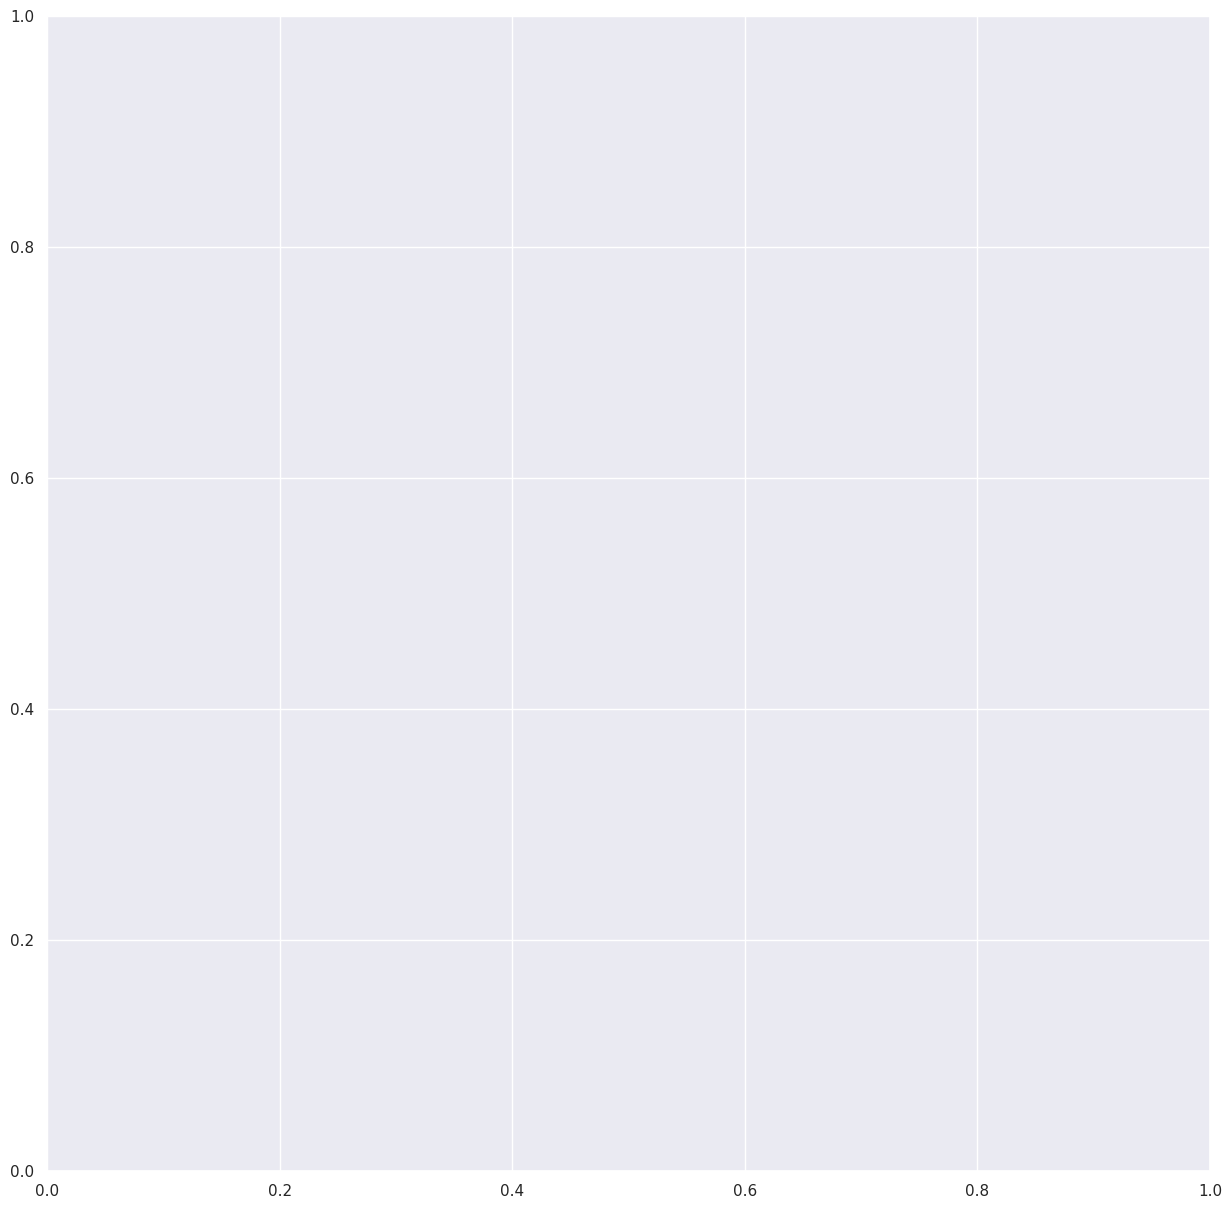

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
fig, ax = plt.subplots(figsize=(15,15))
a = df.corr()
a = abs(a)
a.sort_values(by = ["tool_condition"], ascending=False, inplace=True)
x = a["tool_condition"][1:]
y = a.index[1:]
#print(len(x), len(y))
sns.set()
sns.barplot(y,x, ax=ax)
ax.tick_params(axis = "x", rotation = 90)

In [35]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_score = model.predict(x_test)
print("Trained on {0} observations and scoring with {1} test samples.".format(len(x_train), len(x_test)))
print("Accuracy: {0:0.4f}".format(accuracy_score(y_test, y_score)))
print("F1 Score: {0:0.4f}".format(f1_score(y_test, y_score)))
print("Area under ROC curve: {0:0.4f}".format(roc_auc_score(y_test, y_score)))

Trained on 20228 observations and scoring with 5058 test samples.
Accuracy: 0.9897
F1 Score: 0.9901
Area under ROC curve: 0.9898


In [14]:
# Feature importances
features = [(df.columns[i], v) for i,v in enumerate(model.feature_importances_)]
features.sort(key=lambda x: x[1], reverse = True)
for item in features[:]:
    print("{0}: {1:0.4f}".format(item[0], item[1]))

Z1_ActualPosition: 0.6991
S1_ActualPosition: 0.0455
M1_CURRENT_FEEDRATE: 0.0443
Y1_OutputCurrent: 0.0413
S1_OutputCurrent: 0.0369
Z1_CommandPosition: 0.0287
X1_OutputCurrent: 0.0202
Z1_CommandVelocity: 0.0177
X1_ActualAcceleration: 0.0176
X1_DCBusVoltage: 0.0160
S1_CommandPosition: 0.0070
Machining_Process: 0.0055
S1_CurrentFeedback: 0.0023
Y1_CommandPosition: 0.0022
Y1_CurrentFeedback: 0.0018
Z1_ActualVelocity: 0.0016
S1_OutputVoltage: 0.0016
S1_ActualVelocity: 0.0014
M1_sequence_number: 0.0010
Z1_ActualAcceleration: 0.0009
X1_CurrentFeedback: 0.0009
Y1_OutputVoltage: 0.0009
X1_OutputVoltage: 0.0008
S1_ActualAcceleration: 0.0008
Y1_DCBusVoltage: 0.0006
Z1_CommandAcceleration: 0.0005
S1_DCBusVoltage: 0.0005
Y1_ActualAcceleration: 0.0005
Y1_ActualVelocity: 0.0004
S1_OutputPower: 0.0004
X1_OutputPower: 0.0003
Y1_CommandVelocity: 0.0002
X1_ActualVelocity: 0.0002
S1_CommandAcceleration: 0.0001
Y1_OutputPower: 0.0001
X1_ActualPosition: 0.0000
X1_CommandPosition: 0.0000
X1_CommandVelocity: 0

<Axes: >

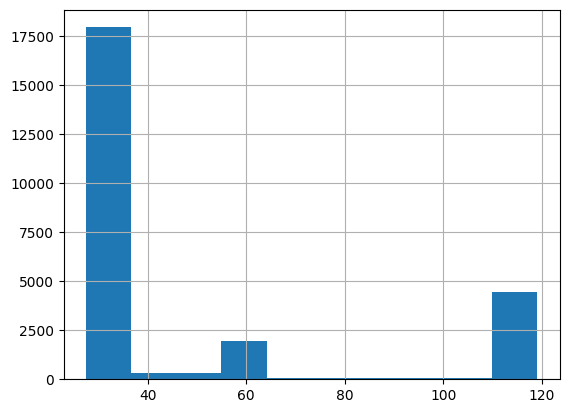

In [10]:
# Z Actual Position distribution
df['Z1_ActualPosition'].hist()